## Building a multilayer perceptron for regression in theano

In [1]:
import theano
import numpy as np
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using gpu device 0: Tesla K40c (CNMeM is enabled with initial size: 95.0% of memory, cuDNN not available)


In [2]:
import sklearn
from sklearn import datasets
from sklearn import model_selection
cali_housing = sklearn.datasets.california_housing.fetch_california_housing()

X = cali_housing.data
y = cali_housing.target
Xy = np.vstack((X.T,y)).T

features_and_target = cali_housing.feature_names + ["target"]
features_to_retrieve = cali_housing.feature_names
target_feature = ["target"]
Xy_df = pd.DataFrame(Xy, columns=features_and_target)

In [3]:
cali_housing.data.shape

(20640, 8)

In [4]:
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
            'AveOccup', 'Latitude', 'Longitude']

target = ['target']

In [5]:
X_train = np.array(Xy_df[features].as_matrix(),dtype="float32")
y_train = np.array(Xy_df[target].as_matrix(),dtype="float32")
X_train = sklearn.preprocessing.minmax_scale(X_train)

X_train, X_test, y_train, y_test =sklearn.model_selection.train_test_split(X_train, y_train)

In [6]:
X_train.shape

(15480, 8)

In [7]:
X_test.shape

(5160, 8)

### Benchmark speed fit vs fit_

- fit: Sends numpy minibatches to the GPU
- fit_: Sends indicies to the GPU (should be much faster)
    
    
Time in CPU and GPU
    
    GPU: dims = [n_features, 5000, 5000, 1] -> 24.182 sec 5 epochs
    CPU: dims = [n_features, 5000, 5000, 1] -> 60.999 sec 5 epochs


In [14]:
#Dropout
import matplotlib
from matplotlib import pyplot as plt
import mlp_regression
import sys

n_epochs = 20
batch_size = 400
evaluate_every = 5
results = {}

In [11]:
n_features = len(features)
dims = [n_features, 5000, 5000, 1]
activations = ["relu", "relu", "identity"]

model_SGD = mlp_regression.MLPRegression(dims,
                                     activations=activations, 
                                     learning_rate=0.01, 
                                     seed=1234,
                                     max_iter=n_epochs,
                                     batch_size=batch_size,
                                     dropout_prob = 0.005,
                                     loss='mean_squared_error',
                                     optimizer='SGD',
                                     random_state=1234)

model_SGD.fit(X_train, 
              y_train,
              n_epochs=20,
              evaluate_every=evaluate_every )


Using SGD optimizer

20/20 train loss: 0.575859 time (sec): 17.915

In [15]:
n_features = len(features)
dims = [n_features, 5000, 5000, 1]
activations = ["relu", "relu", "identity"]

model_SGD = mlp_regression.MLPRegression(dims,
                                     activations=activations, 
                                     learning_rate=0.01, 
                                     seed=1234,
                                     max_iter=n_epochs,
                                     batch_size=batch_size,
                                     dropout_prob = 0.005,
                                     loss='mean_squared_error',
                                     optimizer='SGD',
                                     random_state=1234)

model_SGD.fit(X_train, 
              y_train,
              X_val=None,
              y_val=None,
              X_test=X_test, 
              y_test=y_test,
              n_epochs=n_epochs,
              evaluate_every=evaluate_every )


Using SGD optimizer

20/20 train loss: 0.575859 test loss: 0.581698 time (sec): 18.180

## Testing MLP regression with different optimizers

In [16]:
import matplotlib
from matplotlib import pyplot as plt
import mlp_regression
import sys


dims = [n_features, 400, 400, 1]
n_epochs = 500
batch_size = 400
evaluate_every = 5
results = {}
n_features = len(features)
activations = ["relu", "relu", "identity"]

#### Train with dropout

Time in CPU:

    35/500 train loss: 0.569758 test loss: 0.548427 time (sec): 2.9276

Time in GPU (partial fit recieves numpy minibatches):

    500/500 train loss: 0.435260 test loss: 0.441540 time (sec): 1.4835
    
Time in GPU (partial fit recieves indicies, data as shared variable):

    ??

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15480, 8), (5160, 8), (15480, 1), (5160, 1))

In [18]:
optimizers = ['SGD', 'SGD_momentum', 'RMSprop', 'SGD_nesterov']

In [35]:
results = {}

for optimizer in optimizers:
    model = mlp_regression.MLPRegression(dims,
                                         activations=activations, 
                                         learning_rate=0.01, 
                                         seed=1234,
                                         max_iter=n_epochs,
                                         batch_size=batch_size,
                                         dropout_prob = 0.005,
                                         loss='mean_squared_error',
                                         optimizer=optimizer,
                                         random_state=1234)

    model.fit(X_train, 
                  y_train,
                  X_val=None,
                  y_val=None,
                  X_test=X_test, 
                  y_test=y_test,
                  n_epochs=n_epochs,
                  evaluate_every=evaluate_every )
    
    results[optimizer + '_train'] = model.loss_curve_
    results[optimizer + '_test'] = model.loss_curve_test_    


Using SGD optimizer

500/500 train loss: 0.437511 test loss: 0.445049 time (sec): 1.4659


Using SGD_momentum optimizer

500/500 train loss: 0.348652 test loss: 0.366744 time (sec): 1.4837


Using RMSprop optimizer

500/500 train loss: 0.278922 test loss: 0.367012 time (sec): 1.4982


Using SGD_nesterov optimizer (Warning: Look at the code)

500/500 train loss: 0.340852 test loss: 0.339482 time (sec): 1.6562



In [36]:
# SGD vs SGD_momentum
results_df = pd.DataFrame(results)

In [41]:
results_df.shape

(100, 8)

In [42]:
[x for x in results.keys() if 'train' in x]

['SGD_train', 'RMSprop_train', 'SGD_nesterov_train', 'SGD_momentum_train']

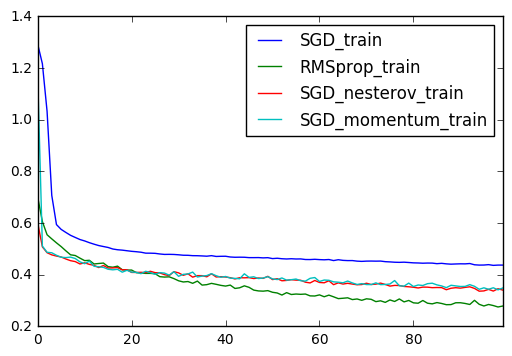

In [43]:
results_df[[x for x in results.keys() if 'train' in x]].plot()

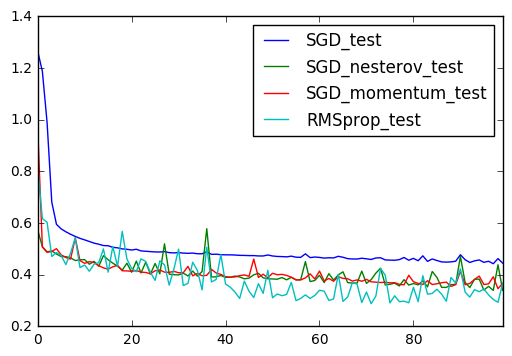

In [45]:
results_df[[x for x in results.keys() if 'test' in x]].plot()

### Easy example of a 2 Layer MLP 

In [ ]:
import theano
from theano import tensor as T

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def relu(X):
    return T.maximum(X, 0.)


def updates_sgd(cost, params):
    """
    Method used to define a list of symbolic updates for theano
    """
    grads = theano.tensor.grad(cost=cost, wrt=params)
    updates = []
    for param,grad in zip(params, grads):
        updates.append([param, param - grad * 0.01 ])

    return updates

In [ ]:
n_features = X_train.shape[1]
n_hid = 200
n_out = 1

sha_W1 = theano.shared(floatX(np.random.normal(np.zeros((n_features,n_hid)), scale=0.1)/np.sqrt(n_features)))
sha_b1 = theano.shared(floatX(np.zeros(n_hid)))

sha_W2 = theano.shared(floatX(np.random.normal(np.zeros((n_hid,n_out)), scale=0.1)/np.sqrt(n_out)))
sha_b2 = theano.shared(floatX(np.zeros(1)))

params = [sha_W1, sha_b1, sha_W2, sha_b2]

sym_Xbatch = T.matrix("sym_Xbatch")
sym_Ybatch = T.matrix("sym_Ybatch")

sym_out = T.dot(relu(T.dot(sym_Xbatch, sha_W1) + sha_b1), sha_W2) + sha_b2
sym_cost = T.mean((sym_out - sym_Ybatch)**2)
sym_updates = updates_sgd(sym_cost, params)

tfunc_fitbatch = theano.function(inputs=[sym_Xbatch, sym_Ybatch], 
                                 outputs=sym_cost,
                                 updates=sym_updates,
                                 allow_input_downcast = True)


tfunc_output = theano.function(inputs=[sym_Xbatch], 
                                outputs=[sym_out,], 
                                 allow_input_downcast = True)


In [ ]:
#sym_out.eval({"sym_Xbatch":X_train[0:100]})

In [ ]:
tfunc_output(X_train[0:2])

In [ ]:
X_train = sklearn.preprocessing.minmax_scale(X_train)

In [ ]:
import sys
cost_evo = []
for i in range(1000):
    cost_evo.append(tfunc_fitbatch(X_train[0:100], y_train[0:100]))